## Evaluating the launch. Let’s assume the route has been launched and we have some initial data on its usage (you can find .CSV attached to the email). Could you take a look at this data to generate insights?
##### a. Does the performance seem on track?
Overtime trend analysis. 
##### b. Are there any findings that would be valuable to share with the product team?
Recurring customer analysis & prediction.

In [251]:
import pandas as pd
import pandasql as ps
import seaborn as sns
import matplotlib.pyplot as plt

In [252]:
df_regional = pd.read_excel('Wise funnel events regional - Data.xlsx')

In [253]:
df_regional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69653 entries, 0 to 69652
Data columns (total 6 columns):
event_name    69653 non-null object
dt            69653 non-null datetime64[ns]
user_id       69653 non-null float64
region        69653 non-null object
platform      69653 non-null object
experience    69653 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.2+ MB


In [254]:
df_regional_categorical = ['event_name', 'region', 'platform', 'experience']

In [255]:
for i in df_regional_categorical:
    print(df_regional[i].value_counts())
    print('')

Transfer Created        43096
Transfer Funded         15579
Transfer Transferred    10978
Name: event_name, dtype: int64

Other      26594
Europe     24445
NorthAm    18614
Name: region, dtype: int64

Android    26182
iOS        24221
Web        19250
Name: platform, dtype: int64

New         37605
Existing    32048
Name: experience, dtype: int64



In [256]:
# Last date removed from df due to incomplete data.
df_regional = df_regional[df_regional["dt"] != "2024-03-01"]

# Descriptive Analysis 

In [257]:
df_regional_copy = df_regional.copy()
df_regional_copy.set_index("dt", inplace=True)

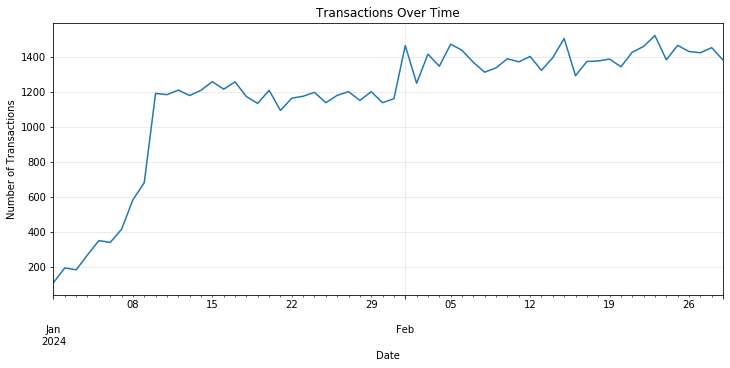

In [198]:
# Plot transactions over time
plt.figure(figsize=(12, 5))
df_regional_copy.resample("D")["user_id"].count().plot()
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.grid(True, alpha=0.3)
plt.show()

# Active users follow the same trend

In [ ]:
# Using only Transfer Transferred as this is the commercially viable metrics for Wise. 

         count       mean       std        min        25%        50%  \
region                                                                 
Europe    60.0  26.886583  5.549870  16.279070  22.731989  25.447713   
NorthAm   60.0  32.103454  3.724327  22.641509  30.144347  31.886469   
Other     60.0  22.008968  2.807701  16.236162  20.101177  21.948849   

               75%        max  
region                         
Europe   30.518395  39.285714  
NorthAm  34.252649  40.000000  
Other    23.768842  29.104478  


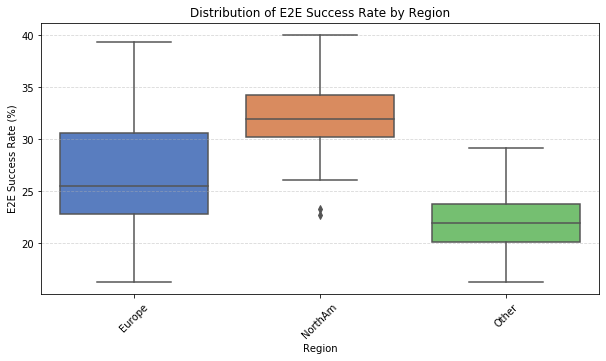

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal

# Step 1: Compute E2E Success Rate per Region
df_region_success = df_regional.groupby(["dt", "region"])[["event_name", "user_id"]].count().reset_index()

# Pivot table to calculate Transfer Created & Transferred counts
df_pivot = df_regional.pivot_table(index=["dt", "region"], columns="event_name", values="user_id", aggfunc="count").fillna(0)

# Calculate E2E Success Rate
df_pivot["success_rate"] = (df_pivot["Transfer Transferred"] / df_pivot["Transfer Created"]) * 100

# Reset index for visualization
df_pivot = df_pivot.reset_index()

# Step 2: Summary Statistics for Each Region
region_stats = df_pivot.groupby("region")["success_rate"].describe()
print(region_stats)

# Step 3: Visualize Success Rate by Region
plt.figure(figsize=(10, 5))
sns.boxplot(x="region", y="success_rate", data=df_pivot, palette="muted")
plt.title("Distribution of E2E Success Rate by Region")
plt.ylabel("E2E Success Rate (%)")
plt.xlabel("Region")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


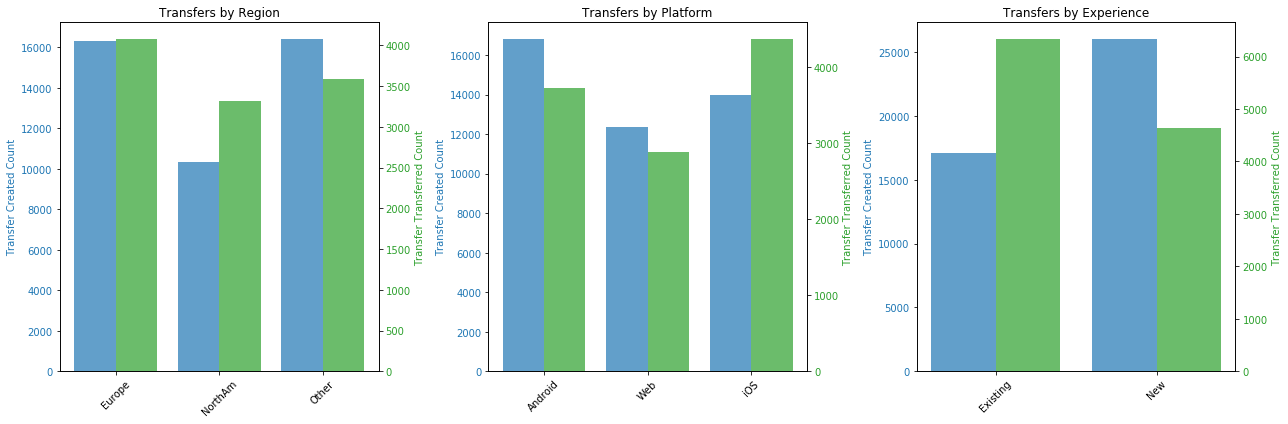

In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter for only 'Transfer Created' and 'Transfer Transferred'
df_filtered = df_regional[df_regional["event_name"].isin(["Transfer Created", "Transfer Transferred"])]

# Group by category (region, platform, experience) and event_name, summing user counts
df_summary = df_filtered.groupby(["event_name", "region", "platform", "experience"])["user_id"].count().reset_index()

# Function to create a pivot table safely
def create_pivot(df, index_col):
    df_pivot = df.groupby([index_col, "event_name"])["user_id"].sum().unstack(fill_value=0)  # Aggregating before pivot
    return df_pivot

# Create pivot tables with summed counts
df_region = create_pivot(df_summary, "region")
df_platform = create_pivot(df_summary, "platform")
df_experience = create_pivot(df_summary, "experience")

# Define bar width and bar positions
bar_width = 0.4

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot grouped bars with dual Y-axis
def plot_dual_axis_bar(ax, df, title):
    categories = df.index
    x = np.arange(len(categories))  # Bar positions

    # Primary Y-axis for Transfer Created
    ax.bar(x, df["Transfer Created"], width=bar_width, color="tab:blue", alpha=0.7, label="Transfer Created")
    ax.set_ylabel("Transfer Created Count", color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")

    # Secondary Y-axis for Transfer Transferred
    ax2 = ax.twinx()
    ax2.bar(x + bar_width, df["Transfer Transferred"], width=bar_width, color="tab:green", alpha=0.7, label="Transfer Transferred")
    ax2.set_ylabel("Transfer Transferred Count", color="tab:green")
    ax2.tick_params(axis="y", labelcolor="tab:green")

    ax.set_title(title)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45)

# Plot each category
plot_dual_axis_bar(axes[0], df_region, "Transfers by Region")
plot_dual_axis_bar(axes[1], df_platform, "Transfers by Platform")
plot_dual_axis_bar(axes[2], df_experience, "Transfers by Experience")

# Layout adjustments
plt.tight_layout()
plt.show()


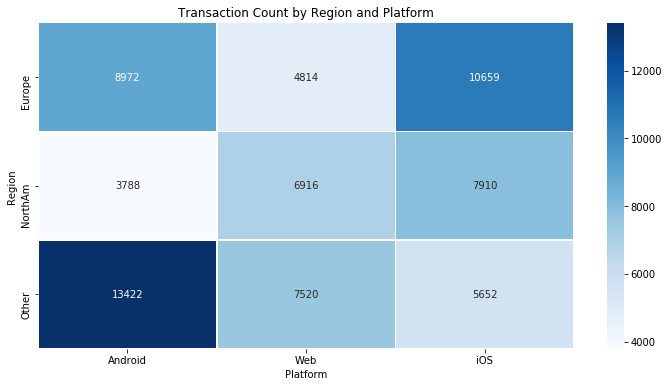

In [112]:
# Group by region and platform to get transaction count
heatmap_data = df_regional.groupby(["region", "platform"])["user_id"].count().reset_index()

# Pivot data for heatmap
heatmap_pivot = heatmap_data.pivot(index="region", columns="platform", values="user_id")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)

plt.title("Transaction Count by Region and Platform")
plt.xlabel("Platform")
plt.ylabel("Region")
plt.show()

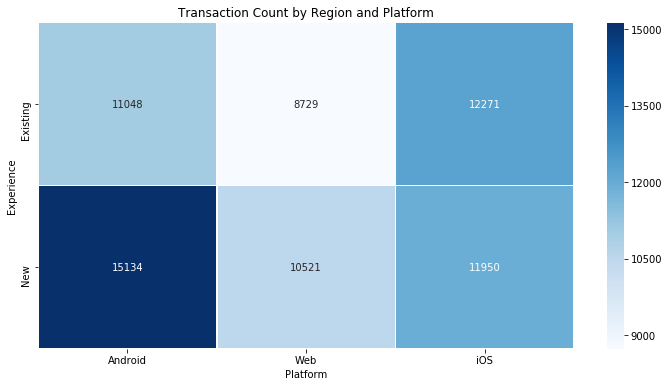

In [114]:
# Group by region and platform to get transaction count
heatmap_data = df_regional.groupby(["experience", "platform"])["user_id"].count().reset_index()

# Pivot data for heatmap
heatmap_pivot = heatmap_data.pivot(index="experience", columns="platform", values="user_id")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)

plt.title("Transaction Count by Region and Platform")
plt.xlabel("Platform")
plt.ylabel("Experience")
plt.show()

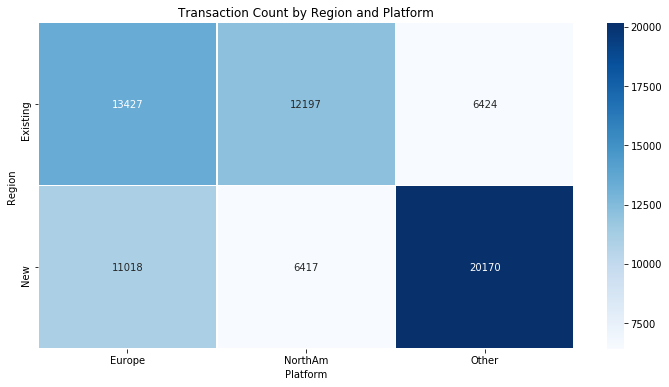

In [115]:
# Group by region and platform to get transaction count
heatmap_data = df_regional.groupby(["experience", "region"])["user_id"].count().reset_index()

# Pivot data for heatmap
heatmap_pivot = heatmap_data.pivot(index="experience", columns="region", values="user_id")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="Blues", annot=True, fmt=".0f", linewidths=0.5)

plt.title("Transaction Count by Region and Platform")
plt.xlabel("Platform")
plt.ylabel("Region")
plt.show()

# End to End Success Rate & Trends

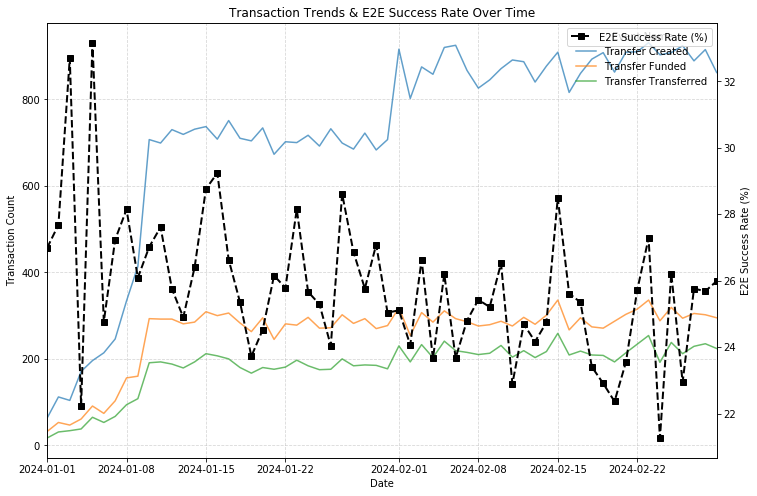

In [196]:
# Group by date and event_name to count transactions
df_grouped = df_regional.groupby([df_regional["dt"].dt.date, "event_name"])["user_id"].count().reset_index()

# Pivot table to get event_name as separate columns
df_pivot = df_grouped.pivot(index="dt", columns="event_name", values="user_id").fillna(0)

# Calculate E2E Success Rate: Transfers Transferred / Transfers Created
df_pivot["success_rate"] = (df_pivot["Transfer Transferred"] / df_pivot["Transfer Created"]) * 100

# Plot setup
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot transaction trends on primary y-axis
df_pivot[["Transfer Created", "Transfer Funded", "Transfer Transferred"]].plot(ax=ax1, linewidth=1.5, alpha=0.7)
ax1.set_xlabel("Date")
ax1.set_ylabel("Transaction Count")
ax1.set_title("Transaction Trends & E2E Success Rate Over Time")
ax1.legend(title="Event Name", loc="upper right", frameon=False)
ax1.grid(True, linestyle="--", alpha=0.5)

# Create secondary y-axis for E2E Success Rate
ax2 = ax1.twinx()
ax2.plot(df_pivot.index, df_pivot["success_rate"], color="black", linestyle="dashed", marker="s", 
         linewidth=2, label="E2E Success Rate (%)")
ax2.set_ylabel("E2E Success Rate (%)")
ax2.legend(loc="upper right")

plt.show()


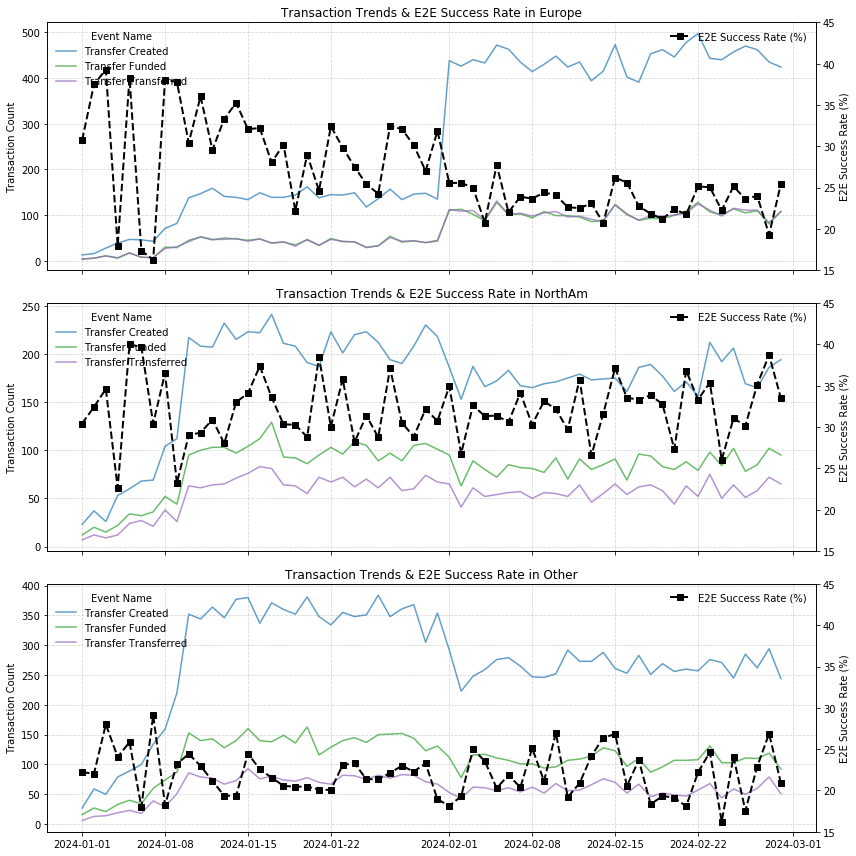

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by date, region, and event_name to count transactions
df_grouped = df_regional.groupby([df_regional["dt"].dt.date, "region", "event_name"])["user_id"].count().reset_index()

# Pivot table to get event_name as separate columns per region
df_pivot = df_grouped.pivot_table(index=["dt", "region"], columns="event_name", values="user_id", aggfunc="sum").fillna(0)

# Calculate E2E Success Rate: Transfers Transferred / Transfers Created
df_pivot["success_rate"] = (df_pivot["Transfer Transferred"] / df_pivot["Transfer Created"]) * 100

# Reset index to access region as a separate column
df_pivot = df_pivot.reset_index()

# Get unique regions
regions = df_pivot["region"].unique()

# Create subplots (one for each region)
fig, axes = plt.subplots(nrows=len(regions), figsize=(12, 12), sharex=True)

# Ensure axes is always iterable (even if one region)
if len(regions) == 1:
    axes = [axes]

# Define colors for transaction trends
event_colors = {
    "Transfer Created": "tab:blue",
    "Transfer Funded": "tab:green",
    "Transfer Transferred": "tab:purple"
}

# Plot each region separately
for ax, region in zip(axes, regions):
    df_region = df_pivot[df_pivot["region"] == region]
    
    # Plot transaction trends on primary y-axis
    for event, color in event_colors.items():
        if event in df_region.columns:  # Ensure column exists before plotting
            ax.plot(df_region["dt"], df_region[event], label=event, color=color, linewidth=1.5, alpha=0.7)
    
    ax.set_ylabel("Transaction Count")
    ax.set_title(f"Transaction Trends & E2E Success Rate in {region}")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Create secondary y-axis for E2E Success Rate
    ax2 = ax.twinx()
    ax2.plot(df_region["dt"], df_region["success_rate"], color="black", linestyle="dashed", marker="s",
             linewidth=2, label="E2E Success Rate (%)")
    ax2.set_ylabel("E2E Success Rate (%)")
    
    # 🔹 **Standardize E2E Success Rate scale across regions**
    ax2.set_ylim(15, 45)  # 🔥 Forces same scale for fair comparison

    # Move legend outside
    ax.legend(title="Event Name", loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

# Set shared X label
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


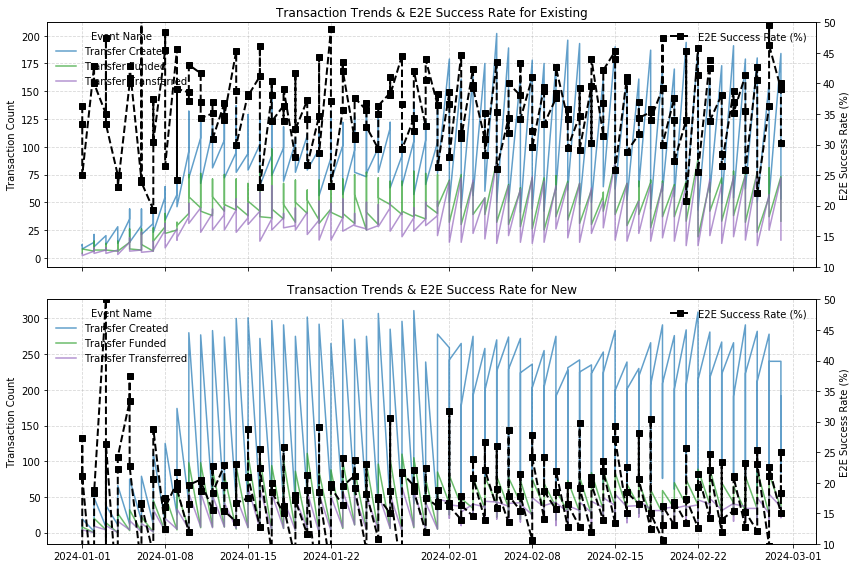

In [213]:
# Group by date, region, experience, and event_name to count transactions
df_grouped = df_regional.groupby([df_regional["dt"].dt.date, "region", "experience", "event_name"])["user_id"].count().reset_index()

# Pivot table to get event_name as separate columns per region & experience
df_pivot = df_grouped.pivot_table(index=["dt", "region", "experience"], columns="event_name", values="user_id", aggfunc="sum").fillna(0)

# Calculate E2E Success Rate: Transfers Transferred / Transfers Created
df_pivot["success_rate"] = (df_pivot["Transfer Transferred"] / df_pivot["Transfer Created"]) * 100

# Reset index to access region and experience as separate columns
df_pivot = df_pivot.reset_index()

# Define colors for transaction trends
event_colors = {
    "Transfer Created": "tab:blue",
    "Transfer Funded": "tab:green",
    "Transfer Transferred": "tab:purple"
}

### **🔹 Plot by Experience**
experiences = df_pivot["experience"].unique()
fig, axes = plt.subplots(nrows=len(experiences), figsize=(12, 8), sharex=True)

# Ensure axes is iterable (even if one experience)
if len(experiences) == 1:
    axes = [axes]

for ax, experience in zip(axes, experiences):
    df_experience = df_pivot[df_pivot["experience"] == experience]
    
    # Plot transaction trends on primary y-axis
    for event, color in event_colors.items():
        if event in df_experience.columns:
            ax.plot(df_experience["dt"], df_experience[event], label=event, color=color, linewidth=1.5, alpha=0.7)
    
    ax.set_ylabel("Transaction Count")
    ax.set_title(f"Transaction Trends & E2E Success Rate for {experience}")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Secondary y-axis for E2E Success Rate
    ax2 = ax.twinx()
    ax2.plot(df_experience["dt"], df_experience["success_rate"], color="black", linestyle="dashed", marker="s",
             linewidth=2, label="E2E Success Rate (%)")
    ax2.set_ylabel("E2E Success Rate (%)")
    ax2.set_ylim(10, 50)  # 🔥 Standardized E2E Success Rate scale across experiences

    ax.legend(title="Event Name", loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


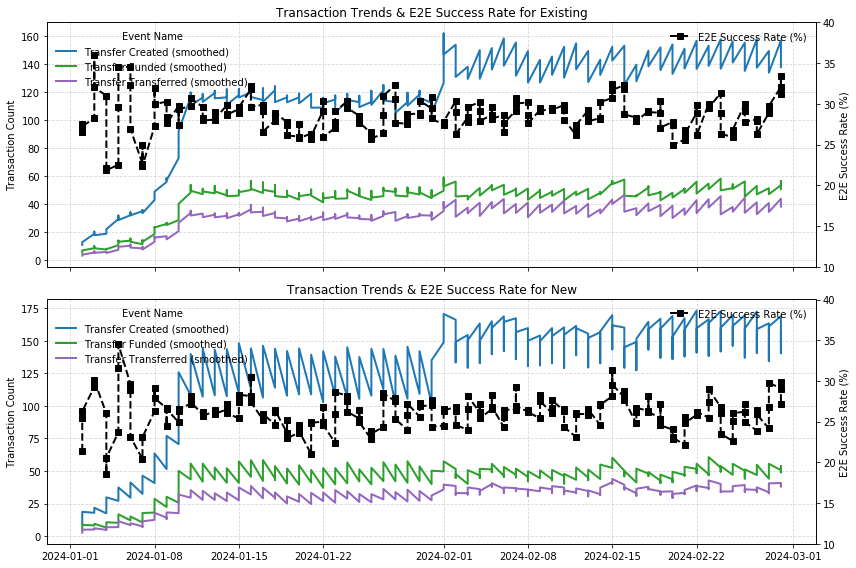

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by date, region, experience, and event_name to count transactions
df_grouped = df_regional.groupby([df_regional["dt"].dt.date, "region", "experience", "event_name"])["user_id"].count().reset_index()

# Pivot table to get event_name as separate columns per region & experience
df_pivot = df_grouped.pivot_table(index=["dt", "region", "experience"], columns="event_name", values="user_id", aggfunc="sum").fillna(0)

# Calculate E2E Success Rate: Transfers Transferred / Transfers Created
df_pivot["success_rate"] = (df_pivot["Transfer Transferred"] / df_pivot["Transfer Created"]) * 100

# Apply rolling window (e.g., 7 days) to smooth the transaction counts and success rates
window_size = 7
df_pivot["Transfer Created_smooth"] = df_pivot["Transfer Created"].rolling(window=window_size).mean()
df_pivot["Transfer Funded_smooth"] = df_pivot["Transfer Funded"].rolling(window=window_size).mean()
df_pivot["Transfer Transferred_smooth"] = df_pivot["Transfer Transferred"].rolling(window=window_size).mean()
df_pivot["success_rate_smooth"] = df_pivot["success_rate"].rolling(window=window_size).mean()

# Reset index to access region and experience as separate columns
df_pivot = df_pivot.reset_index()

# Define colors for transaction trends
event_colors = {
    "Transfer Created": "tab:blue",
    "Transfer Funded": "tab:green",
    "Transfer Transferred": "tab:purple"
}

### **🔹 Plot by Experience**
experiences = df_pivot["experience"].unique()
fig, axes = plt.subplots(nrows=len(experiences), figsize=(12, 8), sharex=True)

# Ensure axes is iterable (even if one experience)
if len(experiences) == 1:
    axes = [axes]

for ax, experience in zip(axes, experiences):
    df_experience = df_pivot[df_pivot["experience"] == experience]
    
    # Plot smoothed transaction trends on primary y-axis
    ax.plot(df_experience["dt"], df_experience["Transfer Created_smooth"], label="Transfer Created (smoothed)", color="tab:blue", linewidth=2)
    ax.plot(df_experience["dt"], df_experience["Transfer Funded_smooth"], label="Transfer Funded (smoothed)", color="tab:green", linewidth=2)
    ax.plot(df_experience["dt"], df_experience["Transfer Transferred_smooth"], label="Transfer Transferred (smoothed)", color="tab:purple", linewidth=2)
    
    ax.set_ylabel("Transaction Count")
    ax.set_title(f"Transaction Trends & E2E Success Rate for {experience}")
    ax.grid(True, linestyle="--", alpha=0.5)

    # Secondary y-axis for smoothed E2E Success Rate
    ax2 = ax.twinx()
    ax2.plot(df_experience["dt"], df_experience["success_rate_smooth"], color="black", linestyle="dashed", marker="s",
             linewidth=2, label="E2E Success Rate (%)")
    ax2.set_ylabel("E2E Success Rate (%)")
    ax2.set_ylim(10, 40)  # 🔥 Standardized E2E Success Rate scale across experiences

    ax.legend(title="Event Name", loc="upper left", frameon=False)
    ax2.legend(loc="upper right", frameon=False)

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Retention Analysis

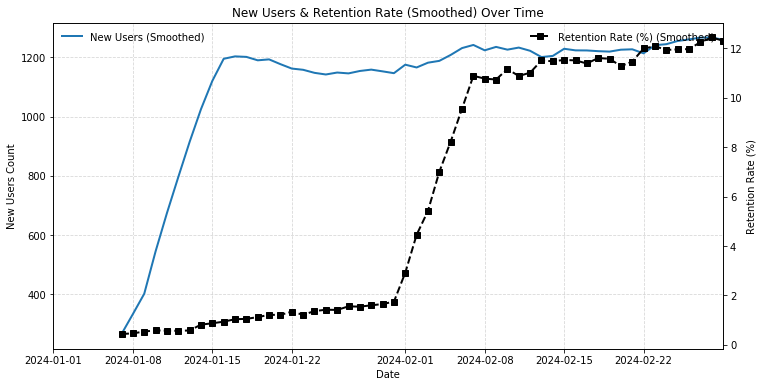

In [142]:
# Sort data by date
df_regional = df_regional.sort_values(by="dt")

# Remove data of last date as it appears incomplete and therefore might be skewed
df_regional = df_regional[df_regional["dt"] != "2024-03-01"]

# Create a helper column to track first occurrence of each user_id
df_regional["first_seen"] = df_regional.groupby("user_id")["dt"].transform("min")

# Identify if the user is a recurring user (transaction date > first_seen date)
df_regional["is_recurring"] = df_regional["dt"] > df_regional["first_seen"]

# Group by date to count new and recurring users
user_trends = df_regional.groupby(df_regional["dt"].dt.date)["is_recurring"].value_counts().unstack(fill_value=0)

# Rename columns
user_trends.columns = ["New Users", "Recurring Users"]

# Calculate Retention Rate
user_trends["Retention Rate (%)"] = (user_trends["Recurring Users"] / 
                                     (user_trends["New Users"] + user_trends["Recurring Users"])) * 100

# Apply rolling average (7-day window) to smooth out the data
user_trends["New Users (Smoothed)"] = user_trends["New Users"].rolling(window=7).mean()
user_trends["Retention Rate (Smoothed)"] = user_trends["Retention Rate (%)"].rolling(window=7).mean()

# Plot setup
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Smoothed New Users on the primary y-axis
user_trends["New Users (Smoothed)"].plot(ax=ax1, color="tab:blue", linewidth=2, label="New Users (Smoothed)")

# Formatting primary axis
ax1.set_xlabel("Date")
ax1.set_ylabel("New Users Count")
ax1.set_title("New Users & Retention Rate (Smoothed) Over Time")
ax1.legend(loc="upper left", frameon=False)
ax1.grid(True, linestyle="--", alpha=0.5)

# Create secondary y-axis for Smoothed Retention Rate
ax2 = ax1.twinx()
ax2.plot(user_trends.index, user_trends["Retention Rate (Smoothed)"], color="black", linestyle="dashed", \
         marker="s", linewidth=2, label="Retention Rate (%) (Smoothed)")

# Formatting secondary axis for Retention Rate
ax2.set_ylabel("Retention Rate (%)")
ax2.legend(loc="upper right", frameon=False)

plt.show()

In [ ]:
# More people started using next month suggests pattern of recurring payment
# potentially salary transfer, direct debit or regular business payment
# and new users are likely to become retained users.

In [ ]:
# below should only use transfer transferred.

# Analysing factors affecting retention

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Ensure 'dt' is in datetime format
df_regional["dt"] = pd.to_datetime(df_regional["dt"])

# Create a helper column to track first occurrence of each user_id
df_regional["first_seen"] = df_regional.groupby("user_id")["dt"].transform("min")

# Identify if the user is recurring (if transaction date > first_seen date)
df_regional["is_recurring"] = df_regional["dt"] > df_regional["first_seen"]

# Create a binary target for retention (1 if the user is retained, 0 if not)
df_regional["is_retained"] = (df_regional["is_recurring"]).astype(int)

# Drop the rows where we can't define retention (e.g., single transaction)
df_regional = df_regional.groupby("user_id").filter(lambda x: len(x) > 1)

# Create the failed_experience column
# Identify users who have a "Transfer Created" but not "Transfer Transferred" on the same day
transfer_created = df_regional[df_regional['event_name'] == 'Transfer Created']
transfer_transferred = df_regional[df_regional['event_name'] == 'Transfer Transferred']

# Merge the two dataframes on user_id and date, indicating "Transfer Created" with no "Transfer Transferred"
merged = pd.merge(transfer_created[['user_id', 'dt']], transfer_transferred[['user_id', 'dt']], 
                  on=['user_id', 'dt'], how='left', indicator=True)

# Create a new column 'failed_experience' to mark "Transfer Created" events without "Transfer Transferred"
merged['failed_experience'] = np.where(merged['_merge'] == 'left_only', 1, 0)

# Now merge this back to the original df_regional
df_regional = pd.merge(df_regional, merged[['user_id', 'dt', 'failed_experience']], 
                       on=['user_id', 'dt'], how='left')

# If no merge occurred, fill failed_experience with 0
df_regional['failed_experience'] = df_regional['failed_experience'].fillna(0).astype(int)

# Features: region, platform, experience, failed_experience, etc.
features = ['region', 'platform', 'experience', 'failed_experience']

# Prepare the data for modeling
X = df_regional[features]
y = df_regional['is_retained']

# One-hot encoding for categorical variables (region, platform, experience)
encoder = OneHotEncoder(drop='first')  # Drop the first category to avoid multicollinearity
X_encoded = encoder.fit_transform(X)

# Get feature names from encoder
encoded_features = encoder.get_feature_names(input_features=features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', ColumnTransformer([
        ('cat', encoder, features)
    ])),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])
# model = Pipeline(steps=[
#     ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
# ])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC score for evaluation
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Feature importance
feature_importance = model.named_steps['classifier'].feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': encoded_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)